# Modeling listing prices

In this notebook, we will use different approaches to model listing price. The target variable in this notebook is the `price` column in our cleaned data. 

In [36]:
# imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

# sklearn
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [5]:
df = pd.read_csv('./../data/austin_listings_clean.csv').drop(columns=['occupancy_rate'])
df.head(5)

,bedrooms,beds,bath,zipcode,host_is_superhost,review_scores_rating,time_quarter,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,price
0,1,2,1.0,78702,1,4.84,Q4,0,0,0,0,0,613000,101.000000
1,0,1,1.0,78704,0,4.97,Q4,0,0,1,0,0,802000,91.666667
2,1,2,1.0,78704,1,4.97,Q4,0,0,1,1,0,802000,159.000000
3,1,1,1.0,78741,0,4.56,Q4,0,1,0,0,0,397000,48.000000
4,2,2,2.0,78702,1,5.00,Q4,0,0,1,0,0,613000,123.000000


## Correlation between different features

C:\Users\masou\AppData\Local\Temp\ipykernel_5392\2380060807.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = round(df.corr(), 2)


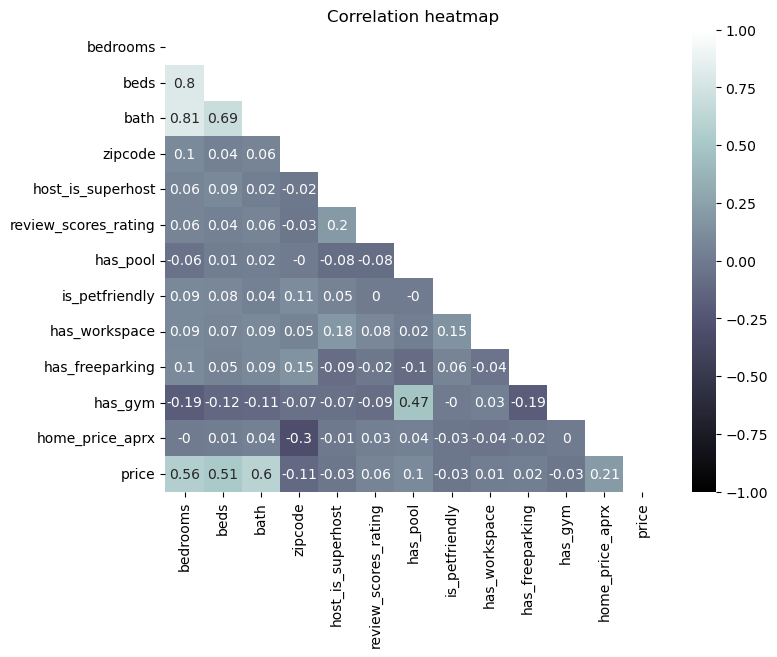

In [14]:
# plot the correlation matrix heatmap
plt.figure(figsize=(8, 6))
corr = round(df.corr(), 2)
mask = np.triu(np.ones_like(corr)) 
sns.heatmap(corr, mask=mask, annot=True, cmap='bone',
            vmin = -1, vmax=1)
plt.title('Correlation heatmap');



From this graph, we can see the listing price shows the highest correlation with bedrooms, baths,and homeprice. Note that categorical features like the time of the listing is not considered here. 

Also, looking at the correlation matrix heatmap, we can say features like beds, bedrooms, and bath are correlated to each other. Another interesting observation is the fact that the houses that have pool are more likely to have gym as well. 

## Null model

We will start our analysis with the null model. For this, the average listing price will be considered as our prediction. 

In [30]:
# create a dataframe for the null model
df_null_model = df.copy()
X = df_null_model.drop(columns=['price'])
y = df_null_model['price']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)
pred = y_train.mean()
print(f'predicted price for the null model: ${int(pred)}/night')

predicted price for the null model: $246/night


In [29]:
preds_train = pred*np.ones(len(y_train))
preds_test = pred*np.ones(len(y_test))
print(f'Train data R2 = {r2_score(y_train, preds_train)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {r2_score(y_test, preds_test)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.0
Train data MAE ($) = 152
Test data R2 = -0.0002555833763804305
Test data MAE ($) = 154


## Simple multiple linear regression

In  this case, we will use a simple linear regression model to predict the house price. Note that there are multiple categorical features (zipcode and time of the listing) that needs to be onehot encoded. We will use a pipeline to chain multiple operations. 

In [49]:
df_lr = df.copy()
X = df_lr.drop(columns=['price'])
y = df_lr['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ])
# create pipeline
lr_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
) 

# fit the model
lr_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_pipeline.predict(X_train)
preds_test = lr_pipeline.predict(X_test)

In [50]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.0947
Train data MAE ($) = 142
Test data R2 = 0.0952
Test data MAE ($) = 144


As we can see, the model is performing very poorly. Let us take a look at errors. 

<Axes: xlabel='price', ylabel='price'>

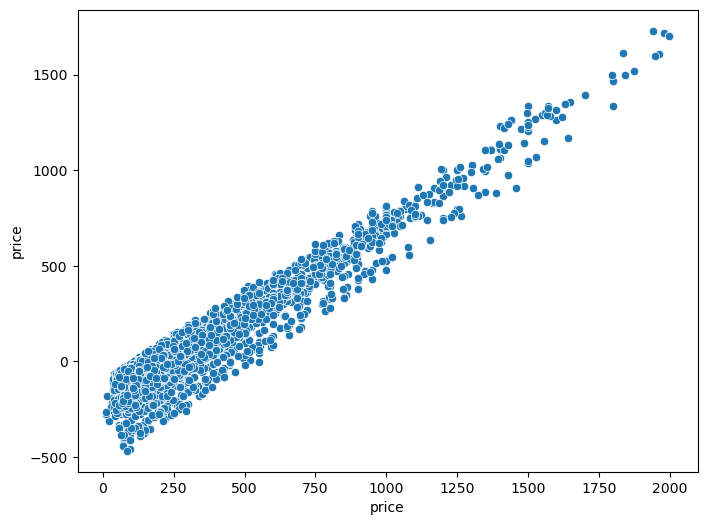

In [52]:
error = y_test - preds_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=error)

In [22]:
X_train.head()

,bedrooms,beds,bath,zipcode,host_is_superhost,review_scores_rating,time_quarter,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx
15341,4,9,2.5,78758,1,5.00,Q3,1,1,0,1,0,398000
32114,4,8,2.0,78734,1,4.88,Q1,0,0,1,1,0,648000
11710,2,2,1.0,78702,1,5.00,Q3,0,0,1,1,0,613000
6410,3,4,2.5,78723,0,4.97,Q4,0,0,1,0,0,502000
21254,1,1,1.0,78704,0,5.00,Q2,1,0,0,1,1,802000


In [17]:
# do a model transformation like log at the end to see if it helps getting a better model for outliers
# do a bit of research to see how we should handle outliers-or consider a case where we focus on a more reasonable price range.
# do error analysis for linear regression comprehensive like plot error vs. other factors as hue
# is correlation between error and other factors
# should I do test train for each model? 
# dimensionality reduction tests
# regularization for linear models
# functions if needed, like scaling and traintest
# something other than gridsearch
# error analysis in each of the models

pipeline with ss and one hot encoder 
we can do polynomial features and regularization
How to pick important features (see Salaar's notebook) or maybe PCA